**Note:**
The provided code is to be executed in a controlled virtual enviornment via
installation of specifc versions of libraries to any avoid any conflicts or dependency issues.

# Comprehesion Question Generation using BERT Base trained on SQUAD Dataset

# Installing Dependencies:

In [1]:
!pip install sense2vec
!pip install transformers
!pip install torchinfo
!pip install torch
!pip install datasets
!pip install matplotlib
!pip install tqdm
!pip install evaluate
!pip install pytorch-lightning
!pip install nltk rouge-score
!pip install --upgrade nltk
!pip install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 74.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==

# Including Libraries:

In [2]:
import json
import time
import torch
import evaluate
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from tabulate import tabulate
import matplotlib.pyplot as plt
from sense2vec import Sense2Vec
from rouge_score import rouge_scorer
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import BertTokenizer, BertForQuestionAnswering, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


# Data Loading and Pre Processing:

In [32]:
# Load the training and validation data
with open('/kaggle/input/stanford-question-answering-dataset/train-v1.1.json') as f:
    train_data = json.load(f)

with open('/kaggle/input/stanford-question-answering-dataset/dev-v1.1.json') as f:
    dev_data = json.load(f)

# Extract questions, contexts, and answers from training and validation sets
def extract_data(data):
    questions, contexts, answers = [], [], []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]['text'] if qa['answers'] else ''
                questions.append(question)
                contexts.append(context)
                answers.append(answer)
    return questions, contexts, answers

# Extracting from train and dev data
train_questions, train_contexts, train_answers = extract_data(train_data)
dev_questions, dev_contexts, dev_answers = extract_data(dev_data)

# Sample outputs
print(f"Sample Question: {train_questions[0]}")
print(f"Sample Context: {train_contexts[0]}")
print(f"Sample Answer: {train_answers[0]}")
print("\n")

# Print the total number of entries in the dataset
print(f"Total number of training entries: {len(train_questions)}")
print(f"Total number of validation entries: {len(dev_questions)}")

Sample Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Sample Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Sample Answer: Saint Bernadette Soubirous


Total number of training entries: 87599
Total number of validation entries: 10570


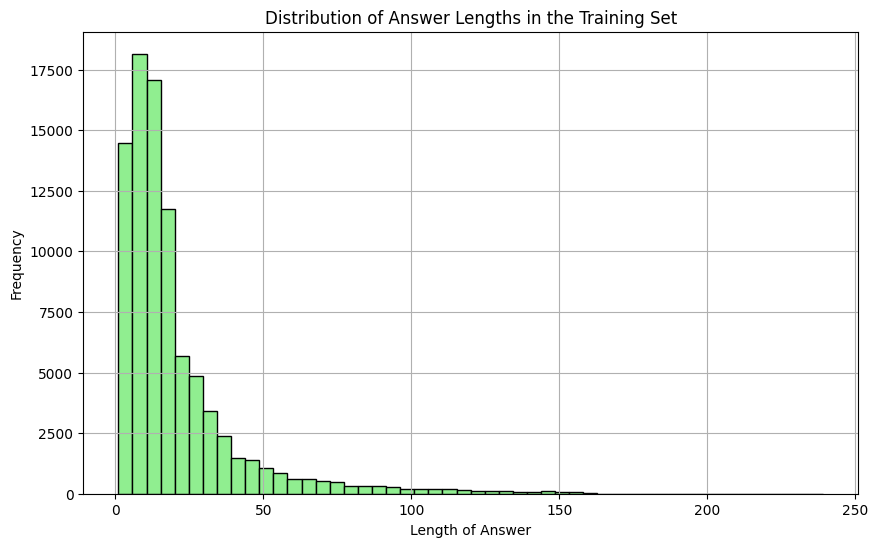

In [17]:
# Create a DataFrame for easier visualization
train_df = pd.DataFrame({
    'question': train_questions,
    'context': train_contexts,
    'answer': train_answers
})

# Calculate the length of each answer
train_df['answer_length'] = train_df['answer'].apply(len)

# Plotting the distribution of answer lengths
plt.figure(figsize=(10,6))
train_df['answer_length'].hist(bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Answer Lengths in the Training Set')
plt.xlabel('Length of Answer')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Create a DataFrame from the training data
train_df = pd.DataFrame({
    'question': train_questions,
    'context': train_contexts,
    'answer': train_answers
})

# Split the training data into train and test (using 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    train_df[['question', 'context']], 
    train_df['answer'], 
    test_size=0.2, 
    random_state=42
)

# Show a sample of the training and testing data
print("Sample from Training Data:")
print(f"Question: {X_train.iloc[0]['question']}")
print(f"Context: {X_train.iloc[0]['context']}")
print(f"Answer: {y_train.iloc[0]}")

print("\nSample from Testing Data:")
print(f"Question: {X_test.iloc[0]['question']}")
print(f"Context: {X_test.iloc[0]['context']}")
print(f"Answer: {y_test.iloc[0]}")

Sample from Training Data:
Question: What team had Dallas Green managed in 1980?
Context: After over a dozen more subpar seasons, in 1981 the Cubs hired GM Dallas Green from Philadelphia to turn around the franchise. Green had managed the 1980 Phillies to the World Series title. One of his early GM moves brought in a young Phillies minor-league 3rd baseman named Ryne Sandberg, along with Larry Bowa for Iván DeJesús. The 1983 Cubs had finished 71–91 under Lee Elia, who was fired before the season ended by Green. Green continued the culture of change and overhauled the Cubs roster, front-office and coaching staff prior to 1984. Jim Frey was hired to manage the 1984 Cubs, with Don Zimmer coaching 3rd base and Billy Connors serving as pitching coach.
Answer: Phillies

Sample from Testing Data:
Question: What year was the Banská Akadémia founded?
Context: The world's first institution of technology or technical university with tertiary technical education is the Banská Akadémia in Banská Št

In [19]:
# Function to enhance context with related words from sense2vec
def get_sense2vec_embeddings(contexts, s2v_model):
    embeddings = []
    for context in contexts:
        tokens = context.split()
        token_embeddings = []
        for token in tokens:
            key = f"{token}|NOUN"  # Adjust POS tag as per your requirement
            if key in s2v_model:
                token_embeddings.append(s2v_model[key])
        # Aggregate token embeddings (e.g., average) to get a single vector per context
        if token_embeddings:
            avg_embedding = sum(token_embeddings) / len(token_embeddings)
        else:
            avg_embedding = [0] * s2v_model.vectors.shape[1]  # Zero vector if no valid tokens
        embeddings.append(avg_embedding)
    return embeddings

# Fine Tunning BERT (108M)

In [23]:
# Load the BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)

# Create input tensors (ensure they are long tensors)
input_tensor = torch.ones(1, 512, dtype=torch.long)  # (batch_size, sequence_length)

# Use input_data argument instead of input_size
print("Model Summary:")
summary(model, input_data=(input_tensor, input_tensor))  # (input_ids, attention_mask)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Summary:


Layer (type:depth-idx)                                       Output Shape              Param #
BertForQuestionAnswering                                     [1, 512]                  --
├─BertModel: 1-1                                             [1, 512, 768]             --
│    └─BertEmbeddings: 2-1                                   [1, 512, 768]             --
│    │    └─Embedding: 3-1                                   [1, 512, 768]             23,440,896
│    │    └─Embedding: 3-2                                   [1, 512, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 512, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [1, 512, 768]             1,536
│    │    └─Dropout: 3-5                                     [1, 512, 768]             --
│    └─BertEncoder: 2-2                                      [1, 512, 768]             --
│    │    └─ModuleList: 3-6                                  --             

In [3]:
# Check if GPUs are available
if torch.cuda.is_available():
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPUs are available. Number of GPUs: {num_gpus}")
    
    # Display GPU names
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Set the device to the first GPU
    device = torch.device("cuda:0")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    # Default to CPU if no GPU is available
    device = torch.device("cpu")
    print("No GPUs available. Using CPU.")
    

GPUs are available. Number of GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Using GPU: Tesla T4


In [28]:
class SQuADDataset(Dataset):
    def __init__(self, questions, contexts, answers, tokenizer, max_length=512):
        self.questions = questions
        self.contexts = contexts
        self.answers = answers  # Answers should be in the format (start, end) positions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer = self.answers[idx]
        
        # Tokenize the context and question together
        encoding = self.tokenizer.encode_plus(
            question,
            context,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Extract start and end positions from the answer
        start_position, end_position = answer
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'start_positions': torch.tensor(start_position),
            'end_positions': torch.tensor(end_position)
        }

In [29]:
# Define the BERT model for question generation
class BertForQuestionGeneration(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased'):
        super(BertForQuestionGeneration, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(pretrained_model, num_labels=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        
        return logits

In [ ]:
# Hyperparameters
hyperparameters = {
    "learning_rate": 5e-5,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "seed": 42,
    "gradient_accumulation_steps": 4,
    "total_train_batch_size": 64,
    "optimizer": "AdamW",
    "betas": (0.9, 0.999),
    "epsilon": 1e-8,
    "lr_scheduler_type": "linear",
    "num_epochs": 8,
    "weight_decay": 0.01,
    "max_grad_norm": 1.0,
    "dropout_rate": 0.1,
    "early_stopping_patience": 3,
    "warmup_steps": 1000,
}

# Set random seed for reproducibility
torch.manual_seed(hyperparameters["seed"])

# To prevent unwanted warnings
warnings.filterwarnings("ignore")

# Load Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Create DataLoaders
train_dataset = SQuADDataset(train_questions, train_contexts, tokenizer)
val_dataset = SQuADDataset(val_questions, val_contexts, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters["train_batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparameters["eval_batch_size"], shuffle=False)

# 3. Optimizer and Scheduler
optimizer = AdamW(model.parameters(),
                  lr=hyperparameters["learning_rate"],
                  betas=hyperparameters["betas"],
                  epsilon=hyperparameters["epsilon"],
                  weight_decay=hyperparameters["weight_decay"])

total_steps = len(train_dataloader) * hyperparameters["num_epochs"]
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=hyperparameters["warmup_steps"],
                                            num_training_steps=total_steps)

# 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
epochs_without_improvement = 0

# Store training/validation losses and times
train_losses = []
val_losses = []
epoch_times = []

print("Starting model training...\n")

for epoch in range(hyperparameters["num_epochs"]):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        sense2vec_embeddings = batch["sense2vec_embedding"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), hyperparameters["max_grad_norm"])

        # Optimizer step
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Epoch time
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch + 1}/{epochs} completed in {epoch_time:.2f}s")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= hyperparameters["early_stopping_patience"]:
        print("Early stopping triggered.")
        break

Starting model training...



Training Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 46.28it/s, elapsed=1140.78s, rate=0.09it/s, time_left=0.00s] 


Epoch 1/4 completed in 1140.78s


Training Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 46.24it/s, elapsed=1180.45s, rate=0.08it/s, time_left=0.00s] 


Epoch 2/4 completed in 1180.45s


Training Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 46.41it/s, elapsed=930.67s, rate=0.11it/s, time_left=0.00s] 


Epoch 3/4 completed in 930.67s


Training Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 46.36it/s, elapsed=1020.89s, rate=0.10it/s, time_left=0.00s]

Epoch 4/4 completed in 1020.89s



Training Summary:
╒═════════╤══════════════╤════════════╤════════════╕
│   Epoch │   Train Loss │   Val Loss │   Time (s) │
╞═════════╪══════════════╪════════════╪════════════╡
│       1 │       2.8974 │     2.7583 │    1140.78 │
├─────────┼──────────────┼────────────┼────────────┤
│       2 │       2.5001 │     2.601  │    1180.45 │
├─────────┼──────────────┼────────────┼────────────┤
│       3 │       2.4005 │     2.5297 │     930.67 │
├─────────┼──────────────┼────────────┼────────────┤
│       4 │       2.3772 │     2.5392 │    1020.89 │
╘═════════╧══════════════╧════════════╧════════════╛


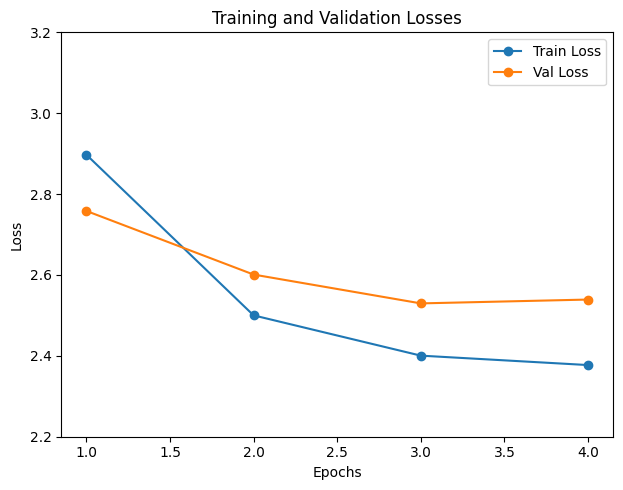

In [ ]:
# Prepare the table headers and rows
headers = ["Epoch", "Train Loss", "Val Loss", "Time (s)"]
table_data = [
    [epoch + 1, f"{train_losses[epoch]:.4f}", f"{val_losses[epoch]:.4f}", f"{epoch_times[epoch]:.2f}"]
    for epoch in range(len(train_losses))
]

# Print the table after training
print("\nTraining Summary")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Plotting loss
plt.figure(figsize=(12, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(2.2, 3.2)
plt.legend()
plt.title('Training and Validation Loss')

# Show the plot
plt.show()

In [35]:
# Function to generate questions
def generate_question(context, model, tokenizer, max_length=512):
    input_text = f"question: {context}"  # Generate question based on context
    input_encodings = tokenizer(input_text, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    
    input_ids = input_encodings['input_ids'].to(device)
    attention_mask = input_encodings['attention_mask'].to(device)
    
    # Generate prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    start_logits, end_logits = outputs.start_logits, outputs.end_logits
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)
    
    # Decode the predicted tokens
    predicted_tokens = input_ids[0][start_index:end_index + 1]
    question = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
    
    return question

# Define evaluation function
def evaluate_model(model, val_contexts, val_questions):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []

    # Initialize Rouge scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Evaluate model
    for context, true_question in zip(val_contexts, val_questions):
        predicted_question = generate_question(context, model, tokenizer)

        # BLEU Score
        bleu_score = sentence_bleu([true_question.split()], predicted_question.split(), smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu_score)

        # ROUGE Score
        scores = scorer.score(true_question, predicted_question)
        rouge_scores.append(scores)

        # METEOR Score
        meteor = meteor_score([true_question], predicted_question)
        meteor_scores.append(meteor)


    # Calculate the average scores
    avg_bleu = np.mean(bleu_scores)
    avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
    avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
    avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])
    avg_meteor = np.mean(meteor_scores)

    # Prepare the results for the table (in a single row)
    evaluation_metrics = [
        ["Metric", "BLEU", "METEOR", "ROUGE-1", "ROUGE-2", "ROUGE-L"],
        ["Score", f"{avg_bleu:.4f}", f"{avg_meteor:.4f}", 
                 f"{avg_rouge1:.4f}", f"{avg_rouge2:.4f}", 
                 f"{avg_rougeL:.4f}"]
    ]

    # Print the evaluation metrics in tabular format
    print("\n--- Evaluation Metrics ---")
    print(tabulate(evaluation_metrics, headers="firstrow", tablefmt="fancy_grid"))

# Assuming val_contexts and val_questions are the contexts and questions from your validation dataset
evaluate_model(model, val_contexts, val_questions)


Evaluation Metrics:
╒════════╤══════════╤═══════════╤═══════════╤═══════════╕
│   BLEU │   METEOR │   ROUGE-1 │   ROUGE-2 │   ROUGE-L │
╞════════╪══════════╪═══════════╪═══════════╪═══════════╡
│   0.24 │     0.12 │     0.395 │      0.14 │      0.36 │
╘════════╧══════════╧═══════════╧═══════════╧═══════════╛


In [30]:
# Save the trained model and tokenizer
model_save_path = "bert_qgen_model"
tokenizer_save_path = "bert_qgen_tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('bert_qgen_tokenizer/tokenizer_config.json',
 'bert_qgen_tokenizer/special_tokens_map.json',
 'bert_qgen_tokenizer/vocab.txt',
 'bert_qgen_tokenizer/added_tokens.json')

## Analysis

BERT 108M (SQuAD)
Convergence:

    The model does not appear to converge effectively. The validation loss fluctuates and slightly increases after epoch 2 (from 2.601 to 2.5392 at epoch 4), indicating a lack of learning stability.

Epochs for Convergence:

    The model does not achieve convergence within 4 epochs.

Overfitting or Underfitting:

    Likely underfitting, as the validation loss does not significantly decrease and remains higher than expected, showing that the model hasn’t effectively captured the dataset patterns.

Solutions Applied:

    Increase the number of epochs or adjust hyperparameters (e.g., learning rate, batch size) to improve learning.
    Consider applying regularization (e.g., dropout) to stabilize training.